In [1]:
import pandas as pd
import urllib.request


data = pd.read_csv('../../../twitter/tweetdata/2018_down2_tweet.csv', error_bad_lines=False)
data = data.append(pd.read_csv('../../../twitter/tweetdata/2018_down2_tweet(e).csv', error_bad_lines=False))




In [2]:
text = data[['text']].astype(str)
text['text'] = text.apply(lambda row: row['text'].replace("/"," "), axis=1)
text['text'] = text.apply(lambda row: row['text'].replace("-"," "), axis=1)
text['text'] = text.apply(lambda row: row['text'].replace("—"," "), axis=1)
#text['main article'] = text.apply(lambda row: row['main article'].replace("",""), axis=1)
text['text'] = text.apply(lambda row: row['text'].replace("*"," "), axis=1)
text['text'] = text.apply(lambda row: row['text'].replace("…"," "), axis=1)
text['text'] = text.apply(lambda row: row['text'].replace("\\"," "), axis=1)



In [3]:
import nltk
text['text'] = text.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

In [4]:
# 소문자 적용 , - 문자 삭제
text['text'] = text['text'].apply(lambda x : [word.lower().replace("-","") for word in x])
# 공백문자 삭제
text['text'] = text['text'].apply(lambda x : [word for word in x if word])

In [5]:
from nltk.tag import pos_tag

text['pos tag'] = text.apply(lambda row: pos_tag(row['text']), axis=1)

In [6]:
# 불용어 품사 제거
text['text'] = text['pos tag'].apply(lambda x: [word[0] for word in x if word[1] not in ('CC','CD','DT','EX','IN','LS','MD','PRP','PRP$','RB','TO','UH','WDT','WP','WP$','WRB')])


In [7]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
text['text'] = text['text'].apply(lambda x: [word for word in x if word not in (stop)])

In [8]:
import csv
stopword_list =[]
f = open('../../../stopword/stop_en.txt', 'r')
reader = csv.reader(f)
for row in reader:
    #print(row[0])
    stopword_list.append(row[0])
    #pass
f.close()

text['text'] = text['text'].apply(lambda x: [word for word in x if word not in stopword_list])

In [9]:
import re
pattern=re.compile(r'\.')
print(pattern.search('abc.de'))

text['text'] = text['text'].apply(lambda x: [word for word in x if pattern.search(word)== None])

<re.Match object; span=(3, 4), match='.'>


In [10]:
number_pattern=re.compile(r'[0-9]\,[0-9]')
text['text'] = text['text'].apply(lambda x: [word for word in x if number_pattern.search(word)== None])

In [11]:
native_number_pattern=re.compile(r'[0-9]')
text['text'] = text['text'].apply(lambda x: [word for word in x if native_number_pattern.search(word)== None])

In [12]:
star_pattern=re.compile(r'[a-z0-9*]\*[a-z0-9*]')
text['text'] = text['text'].apply(lambda x: [word for word in x if star_pattern.search(word)== None])

In [13]:
from nltk.stem import WordNetLemmatizer
text['text'] = text['text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='v') for word in x]) # 동사 
text['text'] = text['text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='a') for word in x]) # 형용사
text['text'] = text['text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='n') for word in x]) # 명사
text['text'] = text['text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='r') for word in x]) # 부사
#print(text)

In [14]:
tokenized_doc = text['text'].apply(lambda x: [word for word in x if len(word) > 3])
#print(tokenized_doc)

In [15]:
article_contents = tokenized_doc.values.tolist()

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

In [17]:
tokenized_doc_tfidf = tokenized_doc.apply(lambda x : ' '.join(x))

In [18]:
article_contents_tfidf = tokenized_doc_tfidf.values.tolist()

In [19]:
vectorizer = TfidfVectorizer()
sp_matrix = vectorizer.fit_transform([ " ".join(article_contents_tfidf) ])

In [20]:
word2id = defaultdict(lambda: 0)

In [21]:
for idx, feature in enumerate(vectorizer.get_feature_names()):
    word2id[feature] = idx

In [22]:
tf_idf_result = []
token_list = []
for i, sent in enumerate([" ".join(article_contents_tfidf)]):
    for token in sent.split() :
        if token not in token_list :
            temp=[]
            temp.append(token)
            temp.append(sp_matrix[i, word2id[token]])
            token_list.append(token)
            tf_idf_result.append(temp)

In [23]:
len(tf_idf_result)

2515

In [24]:
tf_idf_value =[]
for tf_idf_element in tf_idf_result :
    tf_idf_value.append(tf_idf_element[1])
print(len(tf_idf_value))  ## tf-idf 값을 배열에 담음

2515


In [25]:
sentences = article_contents

In [26]:
from gensim.models import Word2Vec

In [27]:
model = Word2Vec(sentences, min_count=1)

In [28]:
len(model.wv.vocab)

2515

In [29]:
X = model[model.wv.vocab]

/Users/hongminpyo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [30]:
from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=4
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
#kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.euclidean_distance, repeats=25)
#euclidean_distance
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
#print(X)
#print(assigned_clusters)

In [31]:
import pandas as pd
import numpy as np
temp_heder = ['raw_data','word','cluster','centroid','distance','tfidf','score','closer#']
temp_cluster_result = pd.DataFrame(columns=temp_heder)

In [32]:
temp_cluster_result['word'] = list(model.wv.vocab)

In [33]:
temp_cluster_result['cluster'] = assigned_clusters

In [34]:
temp_cluster_result['raw_data'] = X.tolist()

In [35]:
#temp_cluster_result['raw_data']
temp_cluster_result['centroid'] = temp_cluster_result['cluster'].apply(lambda x : kclusterer.means()[x])

In [36]:
from sklearn.metrics import pairwise_distances

In [37]:
cosine_centroid_list = []
for cosine_centroid in temp_cluster_result['centroid'] :
    cosine_centroid_list.append(cosine_centroid.tolist())

In [38]:
len(cosine_centroid_list)

2515

In [39]:
temp_distance = pairwise_distances(X,cosine_centroid_list, metric='cosine')

In [40]:
sum(temp_distance[3])

2049.6146791603346

In [41]:
import scipy.spatial.distance as dist

In [42]:
dist.cosine(X[0],cosine_centroid_list[0])

0.1063109314116546

In [43]:
dist.euclidean(X[0],cosine_centroid_list[0])

0.055158031909183176

In [44]:
temp_cluster_result['distance'] = temp_cluster_result.apply(lambda x : dist.cosine(x.raw_data,x.centroid),axis=1)

In [45]:
temp_cluster_result['tfidf'] = tf_idf_value
temp_cluster_result['score'] = temp_cluster_result.apply(lambda x : x.distance + (1- x.tfidf),axis=1)
#temp_cluster_result

In [46]:
temp_cluster_result[temp_cluster_result['cluster']==0].sort_values(by=['score']).head(30)  # 비즈

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
957,"[-0.003046638797968626, -0.0023374678567051888...",card,0,"[-8.295744e-05, -0.0006195299, -0.0002252371, ...",0.632579,0.007298,1.625281,NaN
781,"[0.002085859188809991, -0.002561560133472085, ...",naysayer,0,"[-8.295744e-05, -0.0006195299, -0.0002252371, ...",0.648442,0.001216,1.647226,NaN
1547,"[0.00048095054808072746, 0.0004583203990478068...",betsabemk,0,"[-8.295744e-05, -0.0006195299, -0.0002252371, ...",0.654265,0.001216,1.653049,NaN
1924,"[-0.001101238769479096, 0.0011933865025639534,...",unseizability,0,"[-8.295744e-05, -0.0006195299, -0.0002252371, ...",0.667321,0.002433,1.664888,NaN
2417,"[-6.470868538599461e-05, 0.0007354368572123349...",stellar,0,"[-8.295744e-05, -0.0006195299, -0.0002252371, ...",0.666414,0.001216,1.665197,NaN
2333,"[-0.001964516006410122, -0.0035457054618746042...",tokenised,0,"[-8.295744e-05, -0.0006195299, -0.0002252371, ...",0.667873,0.002433,1.665441,NaN
499,"[-0.003636342706158757, -0.002865428337827325,...",pile,0,"[-8.295744e-05, -0.0006195299, -0.0002252371, ...",0.670807,0.002433,1.668375,NaN
403,"[0.005912963300943375, -0.0017194543033838272,...",ecosystem,0,"[-8.295744e-05, -0.0006195299, -0.0002252371, ...",0.672188,0.003649,1.668539,NaN
2439,"[-0.0033457365352660418, -0.002829570556059479...",wild,0,"[-8.295744e-05, -0.0006195299, -0.0002252371, ...",0.681308,0.001216,1.680092,NaN
807,"[-0.004074217285960913, -0.0005072266212664545...",silvergate,0,"[-8.295744e-05, -0.0006195299, -0.0002252371, ...",0.681913,0.001216,1.680697,NaN


In [47]:
temp_cluster_result[temp_cluster_result['cluster']==1].sort_values(by=['score']).head(30)  # 거래

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
616,"[1.68959450093098e-05, 0.003558363998308778, -...",beat,1,"[-0.00018190936, 0.0008817784, 0.00038434277, ...",0.539446,0.013379,1.526067,NaN
176,"[0.005402929615229368, 0.002041954081505537, -...",seek,1,"[-0.00018190936, 0.0008817784, 0.00038434277, ...",0.549072,0.007298,1.541775,NaN
555,"[0.004945914261043072, -0.0007407260709442198,...",property,1,"[-0.00018190936, 0.0008817784, 0.00038434277, ...",0.577110,0.004865,1.572245,NaN
1833,"[0.002361415885388851, 0.002200886607170105, 0...",version,1,"[-0.00018190936, 0.0008817784, 0.00038434277, ...",0.580155,0.003649,1.576506,NaN
147,"[0.0024749129079282284, 0.004671733360737562, ...",size,1,"[-0.00018190936, 0.0008817784, 0.00038434277, ...",0.589332,0.007298,1.582034,NaN
1408,"[-0.002746151527389884, 0.00550304027274251, -...",client,1,"[-0.00018190936, 0.0008817784, 0.00038434277, ...",0.590870,0.004865,1.586005,NaN
1349,"[-0.002446484751999378, 0.005589896347373724, ...",apompliano,1,"[-0.00018190936, 0.0008817784, 0.00038434277, ...",0.600087,0.003649,1.596439,NaN
640,"[0.002331807278096676, -0.0012466784100979567,...",listen,1,"[-0.00018190936, 0.0008817784, 0.00038434277, ...",0.607790,0.004865,1.602925,NaN
81,"[-0.0016502499347552657, 0.004055890254676342,...",place,1,"[-0.00018190936, 0.0008817784, 0.00038434277, ...",0.613088,0.001216,1.611872,NaN
1081,"[-0.001560941687785089, 0.0045600347220897675,...",libertarian,1,"[-0.00018190936, 0.0008817784, 0.00038434277, ...",0.617924,0.002433,1.615491,NaN


In [48]:
temp_cluster_result[temp_cluster_result['cluster']==2].sort_values(by=['score']).head(40)   # 협업

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
7,"[0.027440674602985382, 0.01436031237244606, 0....",bitcoin,2,"[0.0018246825, 0.001018726, 0.0009102496, 6.03...",0.019021,0.895180,0.123842,NaN
27,"[0.021554283797740936, 0.014853294007480145, 0...",ethereum,2,"[0.0018246825, 0.001018726, 0.0009102496, 6.03...",0.030043,0.119195,0.910848,NaN
90,"[0.008140054531395435, 0.009731719270348549, 0...",http,2,"[0.0018246825, 0.001018726, 0.0009102496, 6.03...",0.049116,0.133790,0.915326,NaN
202,"[0.009528779424726963, 0.008877006359398365, 0...",time,2,"[0.0018246825, 0.001018726, 0.0009102496, 6.03...",0.044724,0.082707,0.962018,NaN
79,"[0.013434895314276218, 0.008619445376098156, 0...",price,2,"[0.0018246825, 0.001018726, 0.0009102496, 6.03...",0.067820,0.085139,0.982681,NaN
185,"[0.01106168981641531, 0.0066410573199391365, 0...",crypto,2,"[0.0018246825, 0.001018726, 0.0009102496, 6.03...",0.079417,0.082707,0.996710,NaN
110,"[0.00883728452026844, 0.005290733650326729, 0....",money,2,"[0.0018246825, 0.001018726, 0.0009102496, 6.03...",0.067904,0.065679,1.002225,NaN
18,"[0.012317896820604801, 0.00852461438626051, 0....",year,2,"[0.0018246825, 0.001018726, 0.0009102496, 6.03...",0.109396,0.094870,1.014526,NaN
76,"[0.008084539324045181, 0.0017187625635415316, ...",people,2,"[0.0018246825, 0.001018726, 0.0009102496, 6.03...",0.089540,0.070544,1.018996,NaN
208,"[0.009590806439518929, 0.009767808020114899, 0...",good,2,"[0.0018246825, 0.001018726, 0.0009102496, 6.03...",0.071944,0.051084,1.020860,NaN


In [49]:
temp_cluster_result[temp_cluster_result['cluster']==3].sort_values(by=['score']).head(20)  # 거래소

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
1653,"[0.0031006168574094772, 0.0026894095353782177,...",capable,3,"[0.0011025122, 0.00039381118, 0.0008079675, -0...",0.446587,0.001216,1.445371,NaN
1141,"[0.004365808796137571, -0.002688234904780984, ...",pull,3,"[0.0011025122, 0.00039381118, 0.0008079675, -0...",0.591780,0.003649,1.588132,NaN
70,"[0.004099625162780285, 0.0022094182204455137, ...",result,3,"[0.0011025122, 0.00039381118, 0.0008079675, -0...",0.605220,0.007298,1.597922,NaN
1773,"[0.003563316073268652, -0.0035681964363902807,...",structure,3,"[0.0011025122, 0.00039381118, 0.0008079675, -0...",0.600446,0.002433,1.598013,NaN
341,"[0.005511786788702011, 0.002922730054706335, 0...",thanksgiving,3,"[0.0011025122, 0.00039381118, 0.0008079675, -0...",0.617420,0.006081,1.611339,NaN
1337,"[0.004200476221740246, -0.0032536606304347515,...",economics,3,"[0.0011025122, 0.00039381118, 0.0008079675, -0...",0.639157,0.002433,1.636725,NaN
2473,"[0.002880845917388797, -0.00020367233082652092...",javascript,3,"[0.0011025122, 0.00039381118, 0.0008079675, -0...",0.638990,0.001216,1.637774,NaN
672,"[0.0035597726237028837, 0.0041749486699700356,...",funny,3,"[0.0011025122, 0.00039381118, 0.0008079675, -0...",0.643590,0.002433,1.641157,NaN
1109,"[0.005353576969355345, -0.004165154881775379, ...",sale,3,"[0.0011025122, 0.00039381118, 0.0008079675, -0...",0.656693,0.003649,1.653044,NaN
656,"[0.0038523925468325615, 0.0007439783657900989,...",flow,3,"[0.0011025122, 0.00039381118, 0.0008079675, -0...",0.655922,0.001216,1.654706,NaN


In [50]:
y_km = temp_cluster_result['cluster'].values

In [51]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

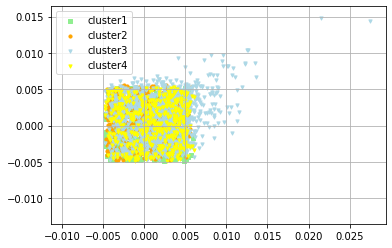

In [52]:
plt.scatter(X[y_km==0,0],X[y_km==0,1],c='lightgreen',marker='s',s=10 , label='cluster1')
plt.scatter(X[y_km==1,0],X[y_km==1,1],c='orange',marker='o',s=10 , label='cluster2')
plt.scatter(X[y_km==2,0],X[y_km==2,1],c='lightblue',marker='v',s=10 , label='cluster3')
plt.scatter(X[y_km==3,0],X[y_km==3,1],c='yellow',marker='v',s=10 , label='cluster4')
#plt.scatter(X[y_km==4,0],X[y_km==4,1],c='red',marker='v',s=10 , label='cluster5')
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='red',marker='*',s=30 , label='center cluster')

plt.legend()
plt.grid(True)
plt.show()

In [53]:
len(temp_cluster_result[temp_cluster_result['cluster']==0]) # 인플

406

In [54]:
len(temp_cluster_result[temp_cluster_result['cluster']==1]) # 비즈 

488

In [55]:
len(temp_cluster_result[temp_cluster_result['cluster']==2]) # 협업

1175

In [56]:
len(temp_cluster_result[temp_cluster_result['cluster']==3]) # 거래소

446

In [57]:
# X[:,1]
from sklearn.cluster import AgglomerativeClustering
import numpy as np

agg = AgglomerativeClustering(n_clusters=4, linkage ="average", affinity="cosine")

assign = agg.fit_predict(X)
# assign = agg.fit(X)

In [58]:
len(assign)

2515

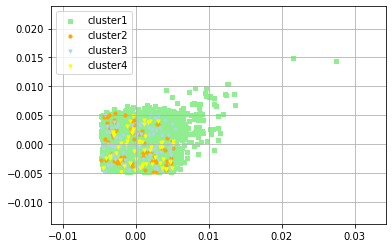

In [59]:
plt.scatter(X[assign==0,0],X[assign==0,1],c='lightgreen',marker='s',s=10 , label='cluster1')
plt.scatter(X[assign==1,0],X[assign==1,1],c='orange',marker='o',s=10 , label='cluster2')
plt.scatter(X[assign==2,0],X[assign==2,1],c='lightblue',marker='v',s=10 , label='cluster3')
plt.scatter(X[assign==3,0],X[assign==3,1],c='yellow',marker='v',s=10 , label='cluster4')
#plt.scatter(X[y_km==4,0],X[y_km==4,1],c='red',marker='v',s=10 , label='cluster5')
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='red',marker='*',s=30 , label='center cluster')

plt.legend()
plt.grid(True)
plt.show()

In [60]:
assign

array([0, 0, 0, ..., 0, 0, 0])

In [61]:
from scipy.cluster.hierarchy import dendrogram

In [62]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

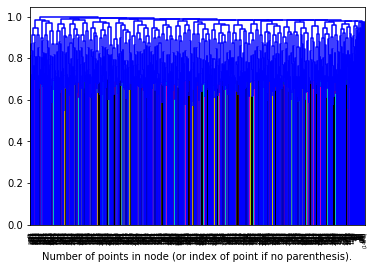

In [63]:

model1 = AgglomerativeClustering(linkage ="average", affinity="cosine", distance_threshold=0, n_clusters=None)

model1.fit(X)

plot_dendrogram(model1, truncate_mode='level', p=20)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [64]:
temp_cluster_result0 = pd.DataFrame(columns=temp_heder)

In [65]:
temp_cluster_result0['word'] = list(model.wv.vocab)

In [66]:
temp_cluster_result0['cluster'] = assign

In [67]:
temp_cluster_result0['raw_data'] = X.tolist()

In [68]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
clf = NearestCentroid()
clf.fit(X, assign)

temp_cluster_result0['centroid'] = temp_cluster_result0['cluster'].apply(lambda x : clf.centroids_[x])

/Users/hongminpyo/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [69]:
cosine_centroid_list0 = []
for cosine_centroid in temp_cluster_result0['centroid'] :
    cosine_centroid_list0.append(cosine_centroid.tolist())

In [70]:
temp_distance0 = pairwise_distances(X,cosine_centroid_list0, metric='cosine')

In [71]:
temp_cluster_result0['distance'] = temp_cluster_result0.apply(lambda x : dist.cosine(x.raw_data,x.centroid),axis=1)

In [72]:
temp_cluster_result0['tfidf'] = tf_idf_value
temp_cluster_result0['score'] = temp_cluster_result0.apply(lambda x : x.distance + (1- x.tfidf),axis=1)

In [73]:
temp_cluster_result0[temp_cluster_result0['cluster']==0].sort_values(by=['score']).head(20)  # 투자, 기술, 비즈니스

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
7,"[0.027440674602985382, 0.01436031237244606, 0....",bitcoin,0,"[0.0010714380769059062, 0.0006975906435400248,...",0.018443,0.895180,0.123264,NaN
27,"[0.021554283797740936, 0.014853294007480145, 0...",ethereum,0,"[0.0010714380769059062, 0.0006975906435400248,...",0.026077,0.119195,0.906881,NaN
90,"[0.008140054531395435, 0.009731719270348549, 0...",http,0,"[0.0010714380769059062, 0.0006975906435400248,...",0.049414,0.133790,0.915624,NaN
202,"[0.009528779424726963, 0.008877006359398365, 0...",time,0,"[0.0010714380769059062, 0.0006975906435400248,...",0.049391,0.082707,0.966684,NaN
79,"[0.013434895314276218, 0.008619445376098156, 0...",price,0,"[0.0010714380769059062, 0.0006975906435400248,...",0.059006,0.085139,0.973867,NaN
185,"[0.01106168981641531, 0.0066410573199391365, 0...",crypto,0,"[0.0010714380769059062, 0.0006975906435400248,...",0.082138,0.082707,0.999431,NaN
110,"[0.00883728452026844, 0.005290733650326729, 0....",money,0,"[0.0010714380769059062, 0.0006975906435400248,...",0.067831,0.065679,1.002152,NaN
18,"[0.012317896820604801, 0.00852461438626051, 0....",year,0,"[0.0010714380769059062, 0.0006975906435400248,...",0.107148,0.094870,1.012279,NaN
710,"[0.013595706783235073, 0.0067168595269322395, ...",security,0,"[0.0010714380769059062, 0.0006975906435400248,...",0.049797,0.034056,1.015741,NaN
76,"[0.008084539324045181, 0.0017187625635415316, ...",people,0,"[0.0010714380769059062, 0.0006975906435400248,...",0.091911,0.070544,1.021367,NaN


In [74]:
temp_cluster_result0[temp_cluster_result0['cluster']==1].sort_values(by=['score']).head(20)  # 이슈, 정치

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
1399,"[0.005160133820027113, -0.0007353870314545929,...",sticky,1,"[-0.00010455676965648308, -0.00013315447722561...",0.544239,0.002433,1.541806,NaN
802,"[-0.0005424673436209559, -0.003888433799147606...",entitle,1,"[-0.00010455676965648308, -0.00013315447722561...",0.605300,0.001216,1.604084,NaN
1386,"[-0.0006548702367581427, 0.0039060942362993956...",bernie,1,"[-0.00010455676965648308, -0.00013315447722561...",0.605544,0.001216,1.604328,NaN
2121,"[-0.0021730782464146614, -0.003209623042494058...",cheerlead,1,"[-0.00010455676965648308, -0.00013315447722561...",0.622831,0.001216,1.621614,NaN
1572,"[-0.0040895650163292885, -0.002770093269646167...",stake,1,"[-0.00010455676965648308, -0.00013315447722561...",0.626945,0.002433,1.624513,NaN
2038,"[0.0043307580053806305, -0.0029370873235166073...",moot,1,"[-0.00010455676965648308, -0.00013315447722561...",0.631798,0.001216,1.630582,NaN
2028,"[0.002844571601599455, -0.004886619746685028, ...",lora,1,"[-0.00010455676965648308, -0.00013315447722561...",0.641160,0.001216,1.639944,NaN
2234,"[0.0004280717403162271, 0.0017065609572455287,...",cybernetic,1,"[-0.00010455676965648308, -0.00013315447722561...",0.651234,0.001216,1.650018,NaN
2041,"[-0.0024010546039789915, -0.002915929304435849...",battle,1,"[-0.00010455676965648308, -0.00013315447722561...",0.661371,0.001216,1.660155,NaN
2207,"[0.0011861209059134126, 0.0002069093461614102,...",trail,1,"[-0.00010455676965648308, -0.00013315447722561...",0.671052,0.001216,1.669836,NaN


In [75]:
temp_cluster_result0[temp_cluster_result0['cluster']==2].sort_values(by=['score']).head(20)  # 암호화폐 , 긍정 

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
2365,"[-0.0024669868871569633, -0.001996023347601294...",fluent,2,"[0.00013093953020870686, -0.000174641114426776...",0.599762,0.001216,1.598546,NaN
1397,"[0.0029338065069168806, -0.004316566977649927,...",illustration,2,"[0.00013093953020870686, -0.000174641114426776...",0.640525,0.001216,1.639309,NaN
2316,"[0.004762216005474329, -0.0030272421427071095,...",marxism,2,"[0.00013093953020870686, -0.000174641114426776...",0.649833,0.001216,1.648617,NaN
2449,"[0.004826642572879791, -0.00183115026447922, 0...",recovery,2,"[0.00013093953020870686, -0.000174641114426776...",0.649914,0.001216,1.648698,NaN
2267,"[0.002767056692391634, -0.003943563438951969, ...",shitlord,2,"[0.00013093953020870686, -0.000174641114426776...",0.650068,0.001216,1.648851,NaN
1683,"[0.001826380263082683, -0.0027923111338168383,...",quit,2,"[0.00013093953020870686, -0.000174641114426776...",0.650113,0.001216,1.648896,NaN
1062,"[-0.0014029470039531589, -0.002728499006479978...",greed,2,"[0.00013093953020870686, -0.000174641114426776...",0.654995,0.001216,1.653779,NaN
258,"[0.0019024070352315903, -0.0019096097676083446...",'why,2,"[0.00013093953020870686, -0.000174641114426776...",0.663923,0.002433,1.661490,NaN
1775,"[0.002279563108459115, 0.0025523498188704252, ...",wrapper,2,"[0.00013093953020870686, -0.000174641114426776...",0.675734,0.001216,1.674518,NaN
1715,"[-0.0017158230766654015, 0.0015565869398415089...",realization,2,"[0.00013093953020870686, -0.000174641114426776...",0.678329,0.001216,1.677112,NaN


In [76]:
temp_cluster_result0[temp_cluster_result0['cluster']==3].sort_values(by=['score']).head(20)  #  이슈 , 기술

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
1550,"[-0.0008339622872881591, 0.004028699826449156,...",burn,3,"[0.0005706404335796833, -0.0006597930914722383...",0.571417,0.001216,1.570200,NaN
433,"[0.0006394520751200616, -0.00417563458904624, ...",salt,3,"[0.0005706404335796833, -0.0006597930914722383...",0.604321,0.001216,1.603105,NaN
95,"[-0.0007598163792863488, -0.003282235004007816...",school,3,"[0.0005706404335796833, -0.0006597930914722383...",0.606223,0.001216,1.605007,NaN
266,"[0.0008393787429668009, -0.0037793077062815428...",temporada,3,"[0.0005706404335796833, -0.0006597930914722383...",0.610531,0.001216,1.609315,NaN
338,"[0.0022122629452496767, -0.003481514984741807,...",career,3,"[0.0005706404335796833, -0.0006597930914722383...",0.640313,0.002433,1.637880,NaN
1273,"[-0.0004119908553548157, 0.0026599233970046043...",airdrop,3,"[0.0005706404335796833, -0.0006597930914722383...",0.647372,0.001216,1.646156,NaN
2082,"[-0.001981068402528763, 0.00021673912124242634...",hundred,3,"[0.0005706404335796833, -0.0006597930914722383...",0.650421,0.001216,1.649204,NaN
1765,"[0.0036635370925068855, 0.000397117983084172, ...",english,3,"[0.0005706404335796833, -0.0006597930914722383...",0.660801,0.002433,1.658368,NaN
1157,"[0.003677093656733632, -0.0025324299931526184,...",attacker,3,"[0.0005706404335796833, -0.0006597930914722383...",0.666014,0.004865,1.661149,NaN
1870,"[-0.0002770521095953882, -0.001236156327649951...",defensible,3,"[0.0005706404335796833, -0.0006597930914722383...",0.662876,0.001216,1.661659,NaN


In [77]:
len(temp_cluster_result0[temp_cluster_result0['cluster']==0]) # 투자,기술,비즈

2311

In [78]:
len(temp_cluster_result0[temp_cluster_result0['cluster']==1]) # 이슈 , 정치

62

In [79]:
len(temp_cluster_result0[temp_cluster_result0['cluster']==2]) # 암호화폐, 긍정 

85

In [80]:
len(temp_cluster_result0[temp_cluster_result0['cluster']==3]) # 이슈, 기술

57

In [81]:
from sklearn import metrics
silhouette_score = metrics.silhouette_score(X, assign, metric='cosine')

In [82]:
silhouette_score

0.01874322

In [83]:
"""
temp_cluster_result['category'] = 1 # 1 영문뉴스, 2 국문뉴스 , 3 twitter
temp_cluster_result.loc[temp_cluster_result['cluster']==0,'label'] = 7 # 비즈
temp_cluster_result.loc[temp_cluster_result['cluster']==1,'label'] = 12 #  가격, 거래소, 돈
temp_cluster_result.loc[temp_cluster_result['cluster']==2,'label'] = 9 # 기술발전
temp_cluster_result.loc[temp_cluster_result['cluster']==3,'label'] = 7 # 비즈
"""

"\ntemp_cluster_result['category'] = 1 # 1 영문뉴스, 2 국문뉴스 , 3 twitter\ntemp_cluster_result.loc[temp_cluster_result['cluster']==0,'label'] = 7 # 비즈\ntemp_cluster_result.loc[temp_cluster_result['cluster']==1,'label'] = 12 #  가격, 거래소, 돈\ntemp_cluster_result.loc[temp_cluster_result['cluster']==2,'label'] = 9 # 기술발전\ntemp_cluster_result.loc[temp_cluster_result['cluster']==3,'label'] = 7 # 비즈\n"

In [84]:
from sklearn import cluster
from sklearn import metrics
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)

KMeans(n_clusters=4)

In [85]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [86]:
kmeans.inertia_

2.1303043365478516

In [87]:
print ("Cluster id labels for inputted data")
print (labels)

Cluster id labels for inputted data
[1 0 0 ... 0 2 0]


In [88]:
cluster_values= list(model.wv.vocab)

In [89]:
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))

Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-2.1303040981292725


In [90]:
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')

In [91]:
print ("Silhouette_score: ")
print (silhouette_score)

Silhouette_score: 
0.02122314


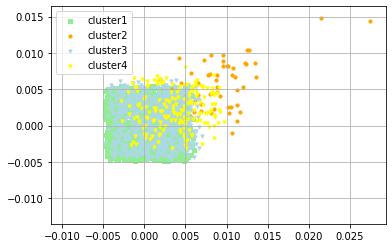

In [92]:
kmeans_label = kmeans.labels_

plt.scatter(X[kmeans_label==0,0],X[kmeans_label==0,1],c='lightgreen',marker='s',s=10 , label='cluster1')
plt.scatter(X[kmeans_label==1,0],X[kmeans_label==1,1],c='orange',marker='o',s=10 , label='cluster2')
plt.scatter(X[kmeans_label==2,0],X[kmeans_label==2,1],c='lightblue',marker='v',s=10 , label='cluster3')
plt.scatter(X[kmeans_label==3,0],X[kmeans_label==3,1],c='yellow',marker='v',s=10 , label='cluster4')
#plt.scatter(X[kmeans_label==4,0],X[kmeans_label==4,1],c='red',marker='v',s=10 , label='cluster5')

plt.legend()
plt.grid(True)
plt.show()

In [93]:
temp_cluster_result1 = pd.DataFrame(columns=temp_heder)
temp_cluster_result1['word'] = list(model.wv.vocab)
temp_cluster_result1['cluster'] = kmeans_label

In [94]:
#temp_cluster_result1[temp_cluster_result1['cluster']==0].head(30) #시도 및 혼돈  # 혼란 부정적 
temp_cluster_result1['raw_data'] = X.tolist()

In [95]:
temp_cluster_result1['centroid'] = temp_cluster_result1['cluster'].apply(lambda x : centroids[x])

In [96]:
euclidean_centroid_list = []
for euclidean_centroid in temp_cluster_result1['centroid'] :
    euclidean_centroid_list.append(euclidean_centroid.tolist())

In [97]:
temp_distance1 = pairwise_distances(X,euclidean_centroid_list, metric='euclidean')

In [98]:
import scipy.spatial.distance as dist

In [99]:
temp_cluster_result1['distance'] = temp_cluster_result1.apply(lambda x : dist.euclidean(x.raw_data,x.centroid),axis=1)

In [100]:
temp_cluster_result1['tfidf'] = tf_idf_value
temp_cluster_result1['score'] = temp_cluster_result1.apply(lambda x : x.distance + (1- x.tfidf),axis=1)
#temp_cluster_result1

In [101]:
temp_cluster_result1[temp_cluster_result1['cluster']==0].sort_values('score',ascending=False).nsmallest(30,'score') # 부정

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
965,"[-0.0026373458094894886, 0.001043916679918766,...",sovereignty,0,"[0.00019339297, 0.0001852146, 0.0001941132, 4....",0.024673,0.007298,1.017375,NaN
446,"[0.002979651326313615, -0.003866637824103236, ...",love,0,"[0.00019339297, 0.0001852146, 0.0001941132, 4....",0.027059,0.008514,1.018545,NaN
470,"[0.0025207262951880693, -0.0004501810471992939...",bubble,0,"[0.00019339297, 0.0001852146, 0.0001941132, 4....",0.027754,0.007298,1.020456,NaN
690,"[0.003933528438210487, 0.00492070009931922, -0...",economist,0,"[0.00019339297, 0.0001852146, 0.0001941132, 4....",0.025955,0.004865,1.021090,NaN
1717,"[0.0003352537169121206, -0.0001619375980226323...",crypto_core,0,"[0.00019339297, 0.0001852146, 0.0001941132, 4....",0.025093,0.003649,1.021444,NaN
1737,"[0.0017616195837035775, 0.003413848113268614, ...",force,0,"[0.00019339297, 0.0001852146, 0.0001941132, 4....",0.025160,0.003649,1.021511,NaN
877,"[0.0060486504808068275, -0.003348374040797353,...",institution,0,"[0.00019339297, 0.0001852146, 0.0001941132, 4....",0.026575,0.004865,1.021710,NaN
469,"[0.001580272102728486, -0.0022993809543550014,...",least,0,"[0.00019339297, 0.0001852146, 0.0001941132, 4....",0.027894,0.006081,1.021812,NaN
1214,"[0.004858317319303751, -0.0013779030414298177,...",paypal,0,"[0.00019339297, 0.0001852146, 0.0001941132, 4....",0.024358,0.002433,1.021925,NaN
707,"[-0.001824379782192409, -0.0013659343821927905...",avoid,0,"[0.00019339297, 0.0001852146, 0.0001941132, 4....",0.029321,0.007298,1.022024,NaN


In [102]:
temp_cluster_result1[temp_cluster_result1['cluster']==1].sort_values('score',ascending=False).nsmallest(40,'score') # 긍정

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
7,"[0.027440674602985382, 0.01436031237244606, 0....",bitcoin,1,"[0.009031996, 0.005667547, 0.004997669, 0.0014...",0.124428,0.895180,0.229248,NaN
90,"[0.008140054531395435, 0.009731719270348549, 0...",http,1,"[0.009031996, 0.005667547, 0.004997669, 0.0014...",0.040203,0.133790,0.906413,NaN
18,"[0.012317896820604801, 0.00852461438626051, 0....",year,1,"[0.009031996, 0.005667547, 0.004997669, 0.0014...",0.033895,0.094870,0.939025,NaN
79,"[0.013434895314276218, 0.008619445376098156, 0...",price,1,"[0.009031996, 0.005667547, 0.004997669, 0.0014...",0.034068,0.085139,0.948928,NaN
185,"[0.01106168981641531, 0.0066410573199391365, 0...",crypto,1,"[0.009031996, 0.005667547, 0.004997669, 0.0014...",0.031992,0.082707,0.949285,NaN
27,"[0.021554283797740936, 0.014853294007480145, 0...",ethereum,1,"[0.009031996, 0.005667547, 0.004997669, 0.0014...",0.074639,0.119195,0.955444,NaN
202,"[0.009528779424726963, 0.008877006359398365, 0...",time,1,"[0.009031996, 0.005667547, 0.004997669, 0.0014...",0.040178,0.082707,0.957471,NaN
76,"[0.008084539324045181, 0.0017187625635415316, ...",people,1,"[0.009031996, 0.005667547, 0.004997669, 0.0014...",0.029007,0.070544,0.958463,NaN
440,"[0.010770877823233604, 0.007974410429596901, 0...",market,1,"[0.009031996, 0.005667547, 0.004997669, 0.0014...",0.029077,0.063246,0.965831,NaN
110,"[0.00883728452026844, 0.005290733650326729, 0....",money,1,"[0.009031996, 0.005667547, 0.004997669, 0.0014...",0.032050,0.065679,0.966371,NaN


In [103]:
temp_cluster_result1[temp_cluster_result1['cluster']==2].sort_values('score',ascending=False).nsmallest(30,'score')  # 제도,한계

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
657,"[0.003011546330526471, 0.001897334004752338, 0...",outperform,2,"[0.0012443487, 0.0006739051, 0.00074440025, -5...",0.031342,0.021893,1.009449,NaN
510,"[0.0020385130774229765, -0.001603959477506578,...",state,2,"[0.0012443487, 0.0006739051, 0.00074440025, -5...",0.026658,0.012163,1.014495,NaN
285,"[0.005699492525309324, -0.0028769136406481266,...",help,2,"[0.0012443487, 0.0006739051, 0.00074440025, -5...",0.030462,0.014595,1.015866,NaN
411,"[-0.000814365572296083, 0.0059804487973451614,...",true,2,"[0.0012443487, 0.0006739051, 0.00074440025, -5...",0.028252,0.012163,1.016089,NaN
616,"[1.68959450093098e-05, 0.003558363998308778, -...",beat,2,"[0.0012443487, 0.0006739051, 0.00074440025, -5...",0.030147,0.013379,1.016768,NaN
277,"[0.0021686633117496967, -0.003519372781738639,...",learn,2,"[0.0012443487, 0.0006739051, 0.00074440025, -5...",0.028971,0.012163,1.016808,NaN
530,"[0.002421664074063301, 0.003971591126173735, 4...",software,2,"[0.0012443487, 0.0006739051, 0.00074440025, -5...",0.028978,0.012163,1.016815,NaN
1255,"[0.0018091222736984491, -0.002805470721796155,...",break,2,"[0.0012443487, 0.0006739051, 0.00074440025, -5...",0.025456,0.008514,1.016943,NaN
2270,"[0.00040415688999928534, 0.000634418276604265,...",photo,2,"[0.0012443487, 0.0006739051, 0.00074440025, -5...",0.030662,0.013379,1.017283,NaN
956,"[0.0021097653079777956, 0.0007082322263158858,...",credit,2,"[0.0012443487, 0.0006739051, 0.00074440025, -5...",0.028297,0.010946,1.017350,NaN


In [104]:
temp_cluster_result1[temp_cluster_result1['cluster']==3].sort_values('score',ascending=False).nsmallest(30,'score') #  기타

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
524,"[0.007919677533209324, -0.00026504669222049415...",short,3,"[0.003692464, 0.0021908781, 0.0018359167, 0.00...",0.032281,0.045002,0.987279,NaN
230,"[0.006142999045550823, 0.005958823021501303, 0...",believe,3,"[0.003692464, 0.0021908781, 0.0018359167, 0.00...",0.030615,0.025542,1.005073,NaN
915,"[0.0015533400001004338, 0.0067637306638062, 0....",keiser,3,"[0.003692464, 0.0021908781, 0.0018359167, 0.00...",0.031031,0.025542,1.005489,NaN
125,"[0.009028038941323757, 0.002201410476118326, 0...",chart,3,"[0.003692464, 0.0021908781, 0.0018359167, 0.00...",0.036024,0.030407,1.005617,NaN
132,"[0.00258462387137115, 0.0010185326682403684, 0...",drop,3,"[0.003692464, 0.0021908781, 0.0018359167, 0.00...",0.029193,0.021893,1.007300,NaN
210,"[0.001142738270573318, 0.000819298904389143, 0...",best,3,"[0.003692464, 0.0021908781, 0.0018359167, 0.00...",0.031694,0.024326,1.007368,NaN
407,"[0.008066394366323948, 0.004274040926247835, 0...",hold,3,"[0.003692464, 0.0021908781, 0.0018359167, 0.00...",0.028073,0.020677,1.007397,NaN
37,"[0.0073018199764192104, 0.003963446244597435, ...",keep,3,"[0.003692464, 0.0021908781, 0.0018359167, 0.00...",0.030564,0.023109,1.007455,NaN
665,"[0.007952697575092316, 0.0018924418836832047, ...",risk,3,"[0.003692464, 0.0021908781, 0.0018359167, 0.00...",0.031985,0.024326,1.007659,NaN
103,"[0.0067618414759635925, 0.0032679466530680656,...",world,3,"[0.003692464, 0.0021908781, 0.0018359167, 0.00...",0.033402,0.025542,1.007861,NaN


In [105]:
len(temp_cluster_result1[temp_cluster_result1['cluster']==0]) # 부정

1409

In [106]:
len(temp_cluster_result1[temp_cluster_result1['cluster']==1]) # 긍정

56

In [107]:
len(temp_cluster_result1[temp_cluster_result1['cluster']==2]) # 제도,한계

875

In [108]:
len(temp_cluster_result1[temp_cluster_result1['cluster']==3]) # 기타

175

In [109]:
agg1 = AgglomerativeClustering(n_clusters=4, linkage ="average", affinity="euclidean")

assign1 = agg1.fit_predict(X)

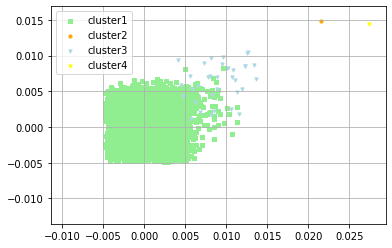

In [110]:
plt.scatter(X[assign1==0,0],X[assign1==0,1],c='lightgreen',marker='s',s=10 , label='cluster1')
plt.scatter(X[assign1==1,0],X[assign1==1,1],c='orange',marker='o',s=10 , label='cluster2')
plt.scatter(X[assign1==2,0],X[assign1==2,1],c='lightblue',marker='v',s=10 , label='cluster3')
plt.scatter(X[assign1==3,0],X[assign1==3,1],c='yellow',marker='v',s=10 , label='cluster4')
#plt.scatter(X[y_km==4,0],X[y_km==4,1],c='red',marker='v',s=10 , label='cluster5')
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='red',marker='*',s=30 , label='center cluster')

plt.legend()
plt.grid(True)
plt.show()

In [111]:
temp_cluster_result2 = pd.DataFrame(columns=temp_heder)
temp_cluster_result2['word'] = list(model.wv.vocab)
temp_cluster_result2['cluster'] = assign1
temp_cluster_result2['raw_data'] = X.tolist()
clf1 = NearestCentroid()
clf1.fit(X, assign1)

NearestCentroid()

In [112]:
temp_cluster_result2['centroid'] = temp_cluster_result2['cluster'].apply(lambda x : clf1.centroids_[x])

In [113]:
euclidean_centroid_list2 = []
for euclidean_centroid in temp_cluster_result2['centroid'] :
    euclidean_centroid_list2.append(euclidean_centroid.tolist())

In [114]:

temp_distance2 = pairwise_distances(X,euclidean_centroid_list2, metric='euclidean')

In [115]:
temp_cluster_result2['distance'] = temp_cluster_result2.apply(lambda x : dist.euclidean(x.raw_data,x.centroid),axis=1)

In [116]:
temp_cluster_result2['tfidf'] = tf_idf_value
temp_cluster_result2['score'] = temp_cluster_result2.apply(lambda x : x.distance + (1- x.tfidf),axis=1)

In [117]:
temp_cluster_result2[temp_cluster_result2['cluster']==0].sort_values(by=['score']).head(20) #  비즈, 이슈 , 투자

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
189,"[0.008017131127417088, 0.00427668122574687, 0....",last,0,"[0.0008662350010126829, 0.0005244336207397282,...",0.051702,0.060814,0.990888,NaN
524,"[0.007919677533209324, -0.00026504669222049415...",short,0,"[0.0008662350010126829, 0.0005244336207397282,...",0.042960,0.045002,0.997957,NaN
312,"[0.006497547030448914, 0.004172197077423334, 0...",bank,0,"[0.0008662350010126829, 0.0005244336207397282,...",0.052154,0.049867,1.002287,NaN
657,"[0.003011546330526471, 0.001897334004752338, 0...",outperform,0,"[0.0008662350010126829, 0.0005244336207397282,...",0.032291,0.021893,1.010398,NaN
525,"[0.005347191356122494, 0.0030716063920408487, ...",banker,0,"[0.0008662350010126829, 0.0005244336207397282,...",0.034164,0.020677,1.013487,NaN
407,"[0.008066394366323948, 0.004274040926247835, 0...",hold,0,"[0.0008662350010126829, 0.0005244336207397282,...",0.035030,0.020677,1.014353,NaN
510,"[0.0020385130774229765, -0.001603959477506578,...",state,0,"[0.0008662350010126829, 0.0005244336207397282,...",0.027089,0.012163,1.014926,NaN
230,"[0.006142999045550823, 0.005958823021501303, 0...",believe,0,"[0.0008662350010126829, 0.0005244336207397282,...",0.041185,0.025542,1.015643,NaN
196,"[0.0033486548345535994, 0.005083028227090836, ...",talk,0,"[0.0008662350010126829, 0.0005244336207397282,...",0.051076,0.035272,1.015804,NaN
132,"[0.00258462387137115, 0.0010185326682403684, 0...",drop,0,"[0.0008662350010126829, 0.0005244336207397282,...",0.037778,0.021893,1.015885,NaN


In [118]:
temp_cluster_result2[temp_cluster_result2['cluster']==1].sort_values(by=['score']).head(20) #  암호화폐

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
27,"[0.021554283797740936, 0.014853294007480145, 0...",ethereum,1,"[0.021554283797740936, 0.014853294007480145, 0...",0.0,0.119195,0.880805,NaN


In [119]:
temp_cluster_result2[temp_cluster_result2['cluster']==2].sort_values(by=['score']).head(20) # 기술, 거래

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
90,"[0.008140054531395435, 0.009731719270348549, 0...",http,2,"[0.009078405797481537, 0.006361780222505331, 0...",0.038273,0.133790,0.904483,NaN
18,"[0.012317896820604801, 0.00852461438626051, 0....",year,2,"[0.009078405797481537, 0.006361780222505331, 0...",0.033176,0.094870,0.938307,NaN
79,"[0.013434895314276218, 0.008619445376098156, 0...",price,2,"[0.009078405797481537, 0.006361780222505331, 0...",0.032916,0.085139,0.947776,NaN
185,"[0.01106168981641531, 0.0066410573199391365, 0...",crypto,2,"[0.009078405797481537, 0.006361780222505331, 0...",0.031070,0.082707,0.948363,NaN
202,"[0.009528779424726963, 0.008877006359398365, 0...",time,2,"[0.009078405797481537, 0.006361780222505331, 0...",0.038293,0.082707,0.955586,NaN
76,"[0.008084539324045181, 0.0017187625635415316, ...",people,2,"[0.009078405797481537, 0.006361780222505331, 0...",0.029132,0.070544,0.958588,NaN
110,"[0.00883728452026844, 0.005290733650326729, 0....",money,2,"[0.009078405797481537, 0.006361780222505331, 0...",0.030726,0.065679,0.965047,NaN
440,"[0.010770877823233604, 0.007974410429596901, 0...",market,2,"[0.009078405797481537, 0.006361780222505331, 0...",0.028802,0.063246,0.965556,NaN
225,"[0.008214072324335575, 0.004419262055307627, 0...",think,2,"[0.009078405797481537, 0.006361780222505331, 0...",0.027860,0.055949,0.971911,NaN
160,"[0.005628385115414858, 0.007169676013290882, 0...",trade,2,"[0.009078405797481537, 0.006361780222505331, 0...",0.030934,0.057165,0.973769,NaN


In [120]:
temp_cluster_result2[temp_cluster_result2['cluster']==3].sort_values(by=['score']).head(20) # 암호화폐 

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
7,"[0.027440674602985382, 0.01436031237244606, 0....",bitcoin,3,"[0.027440674602985382, 0.01436031237244606, 0....",0.0,0.89518,0.10482,NaN


In [121]:
len(temp_cluster_result2[temp_cluster_result2['cluster']==0]) # 비즈 이슈 투자

2478

In [122]:
len(temp_cluster_result2[temp_cluster_result2['cluster']==1]) # 암호화폐

1

In [123]:
len(temp_cluster_result2[temp_cluster_result2['cluster']==2]) # 기술, 거래

35

In [124]:
len(temp_cluster_result2[temp_cluster_result2['cluster']==3]) # 암호화폐 

1

In [125]:
silhouette_score1 = metrics.silhouette_score(X, assign1, metric='euclidean')

In [126]:
silhouette_score1

0.40923396

In [ ]:
agg2 = AgglomerativeClustering(n_clusters=4, linkage ="ward", affinity="euclidean")

assign2 = agg2.fit_predict(X)

In [ ]:
plt.scatter(X[assign2==0,0],X[assign2==0,1],c='lightgreen',marker='s',s=10 , label='cluster1')
plt.scatter(X[assign2==1,0],X[assign2==1,1],c='orange',marker='o',s=10 , label='cluster2')
plt.scatter(X[assign2==2,0],X[assign2==2,1],c='lightblue',marker='v',s=10 , label='cluster3')
plt.scatter(X[assign2==3,0],X[assign2==3,1],c='yellow',marker='v',s=10 , label='cluster4')
#plt.scatter(X[y_km==4,0],X[y_km==4,1],c='red',marker='v',s=10 , label='cluster5')
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='red',marker='*',s=30 , label='center cluster')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
temp_cluster_result3 = pd.DataFrame(columns=temp_heder)
temp_cluster_result3['word'] = list(model.wv.vocab)
temp_cluster_result3['cluster'] = assign2
temp_cluster_result3['raw_data'] = X.tolist()
clf2 = NearestCentroid()
clf2.fit(X, assign2)

In [ ]:
temp_cluster_result3['centroid'] = temp_cluster_result3['cluster'].apply(lambda x : clf2.centroids_[x])

In [ ]:
euclidean_centroid_list3 = []
for euclidean_centroid in temp_cluster_result3['centroid'] :
    euclidean_centroid_list3.append(euclidean_centroid.tolist())

In [ ]:
temp_distance3 = pairwise_distances(X,euclidean_centroid_list3, metric='euclidean')

In [ ]:
temp_cluster_result3['distance'] = temp_cluster_result3.apply(lambda x : dist.euclidean(x.raw_data,x.centroid),axis=1)

temp_cluster_result3['tfidf'] = tf_idf_value
temp_cluster_result3['score'] = temp_cluster_result3.apply(lambda x : x.distance + (1- x.tfidf),axis=1)

In [ ]:
temp_cluster_result3[temp_cluster_result3['cluster']==0].sort_values(by=['score']).head(20)

In [ ]:
temp_cluster_result3[temp_cluster_result3['cluster']==1].sort_values(by=['score']).head(20)

In [ ]:
temp_cluster_result3[temp_cluster_result3['cluster']==2].sort_values(by=['score']).head(20)

In [ ]:
temp_cluster_result3[temp_cluster_result3['cluster']==3].sort_values(by=['score']).head(20)

In [ ]:
len(temp_cluster_result3[temp_cluster_result3['cluster']==0])

In [ ]:
len(temp_cluster_result3[temp_cluster_result3['cluster']==1])

In [ ]:
len(temp_cluster_result3[temp_cluster_result3['cluster']==2])

In [ ]:
len(temp_cluster_result3[temp_cluster_result3['cluster']==3])

In [ ]:
silhouette_score3 = metrics.silhouette_score(X, assign2, metric='euclidean')

In [ ]:
silhouette_score3

In [ ]:

"""
temp_cluster_result1['result'] = 1 # 1 상승 2 하락 3 보합
temp_cluster_result['result'] = 1
temp_cluster_result1['Silhouette'] = 0.7476496# 1 상승 2 하락 3 보합
temp_cluster_result['Silhouette'] = 0.7476496
 """

In [ ]:
#temp_cluster_result1.to_csv("../cluster/en_news/2017_up2/en_news_2017_up2_euclidean.csv")
#temp_cluster_result.to_csv("../cluster/en_news/2017_up2/en_news_2017_up2_cosine.csv")